# SmartSat Hyperspectral Notes

#### Imports



In [1]:
## Imports

import os
import glob
import json
import joblib
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from rios import applier, fileinfo
from netCDF4 import Dataset
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull


gdal.UseExceptions()

# Set the location of the proj library
# os.environ['PROJ_LIB'] = '/home/pete/miniforge3/envs/kea/share/proj'



## ENMAP

Search for [ENMAP](https://explore.eo-lab.org/search)

ENMAP comes as PIXEL interleaved COG, it's slow to open in QGIS. I run the `src/reformat_enmap.sh` shell script to reformat it to tiled BAND interleaved with tiled overviews


In [3]:
# Read the enmap_wavelenths.csv file with three columns: band, wavelength, and fwhm
def read_enmap_wavelengths(csv_file):
    with open(csv_file, 'r') as f:
        lines = f.readlines()
    lines = [line.strip().split(',') for line in lines[1:]]
    bands = [int(line[0]) for line in lines]
    wavelengths = [float(line[1]) for line in lines]
    fwhms = [float(line[2]) for line in lines]
    return bands, wavelengths, fwhms


# Set the band descriptions in a GeoTIFF file
def set_band_descriptions(geotiff_path, band_names):
    ds = gdal.Open(geotiff_path, gdal.GA_Update)
    if ds is None:
        raise ValueError(f"Could not open the GeoTIFF file: {geotiff_path}")
    
    num_bands = ds.RasterCount
    if len(band_names) != num_bands:
        raise ValueError("The number of band names must match the number of raster bands.")
    
    for i, band_name in enumerate(band_names, start=1):
        band = ds.GetRasterBand(i)
        band.SetDescription(str(band_name))  # Use the band index (starting at 1)
        band.SetScale(0.001)  # Reset the scale and offset

    del ds  # Close and save changes to the dataset



bands, wavelengths, fwhms = read_enmap_wavelengths('enmap_wavelengths.csv')

enmap_files = glob.glob('ENMAP*.tif')
for enmap_file in enmap_files:
    set_band_descriptions(enmap_file, wavelengths)


## EMIT

Search for [EMIT](https://earth.jpl.nasa.gov/emit/data/data-portal/coverage-and-forecasts/)

### Importing EMIT data
The `src/gdal_import_emit.py` script can be used to import EMIT data into GDAL formats, applying the GLT so the data is mapped to a grid.

### Sampling EMIT NETCDF


/tmp/ipykernel_23810/489123949.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dat = np.array(nc_ds['reflectance'])
/tmp/ipykernel_23810/489123949.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mask = np.array(nc_ds['mask'])


Original shape: (285, 1589760)
Shape after masking: (285, 1587236)
Shape after removing wild values: (285, 1587231)


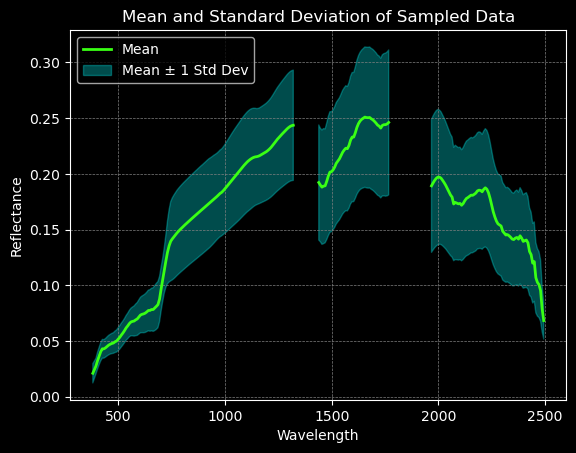

In [74]:

import numpy as np
from netCDF4 import Dataset
import os

def extract_and_mask_data(emit_file):
    mask_file = emit_file.replace('RFL', 'MASK')
    
    # Extract variables and metadata from the NetCDF file
    nc_ds = Dataset(emit_file, 'r', format='NETCDF4')
    dat = np.array(nc_ds['reflectance'])
    # Reshape/rotate to (bands, lines, columns)
    dat = np.moveaxis(dat, 2, 0)
    # Reshape to (bands, pixels)
    dat = dat.reshape((dat.shape[0], -1))
    # Create an x-axis for plotting
    wavelengths = nc_ds.groups.get('sensor_band_parameters').variables['wavelengths'][:]
    nc_ds.close()
    
    # Check if mask file exists
    if os.path.exists(mask_file):
        # Extract the mask from the NetCDF file
        nc_ds = Dataset(mask_file, 'r', format='NETCDF4')
        mask = np.array(nc_ds['mask'])
        # Aggregate mask is the 7th band
        mask = mask[:, :, 7] == 0
        # Reshape/rotate to (lines, columns)
        mask = np.moveaxis(mask, 1, 0)
        # Reshape to (pixels)
        mask = mask.reshape(-1)
        nc_ds.close()
        
        # Mask the data
        print("Original shape:", dat.shape)
        dat = dat[:, mask]
        print("Shape after masking:", dat.shape)
    else:
        print("Mask file does not exist. Skipping masking.")

    # Remove wild values
    dat = dat[:, np.max(dat, axis=0) < 0.9]
    print("Shape after removing wild values:", dat.shape)
    
    return dat, wavelengths


def plot_data(dat, wavelengths):
    # Plot the mean and standard deviation of the sampled data
    mean = np.mean(dat, axis=1)
    std_dev = np.std(dat, axis=1)

    # Mask values less than 0 by setting them to NaN
    mean[mean < 0] = np.nan
    std_dev[std_dev < 0] = np.nan

    # Set the black background
    plt.style.use('dark_background')

    # Plot the mean with a neon color
    plt.plot(wavelengths, mean, label='Mean', color='#39FF14', linewidth=2)  # Neon green line

    # Plot the standard deviation as a shaded area with a neon color
    plt.fill_between(wavelengths, mean - std_dev, mean + std_dev, color='#00FFFF', alpha=0.3, label='Mean ± 1 Std Dev')  # Neon cyan shading

    # Customize the plot with labels, title, legend, and grid
    plt.xlabel('Wavelength', color='white')
    plt.ylabel('Reflectance', color='white')
    plt.title('Mean and Standard Deviation of Sampled Data', color='white')
    plt.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()

# Usage:
emit_file = 'EMIT_L2A_RFL_001_20240721T024222_2420301_008.nc'
dat, wavelengths = extract_and_mask_data(emit_file)
plot_data(dat, wavelengths)


## Clean the DATA

In [75]:
# Find the indicies of the bands where the minumum is all less than 0
bad_bands = np.all(dat < 0, axis=1)
print(f'Bad bands: {np.where(bad_bands)[0]}')

# Remove outliers using sklearn IsolationForest
clf = IsolationForest(contamination=0.10)
outliers = clf.fit_predict(dat.T)
sampled_data = dat[:, outliers == 1].T
# Print the proportion of outliers
print(f'Proportion of outliers: {np.sum(outliers == -1) / len(outliers)}')

# Subsample a maximum of 1 million pixels
num_samples = 1000000
sample_pixels = np.random.choice(sampled_data.shape[0], min(num_samples,sampled_data.shape[0]), replace=False)
sampled_data = sampled_data[sample_pixels]
print(sampled_data.shape)



Bad bands: [127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212]
Proportion of outliers: 0.09999993699719827
(1000000, 285)


### SMACC

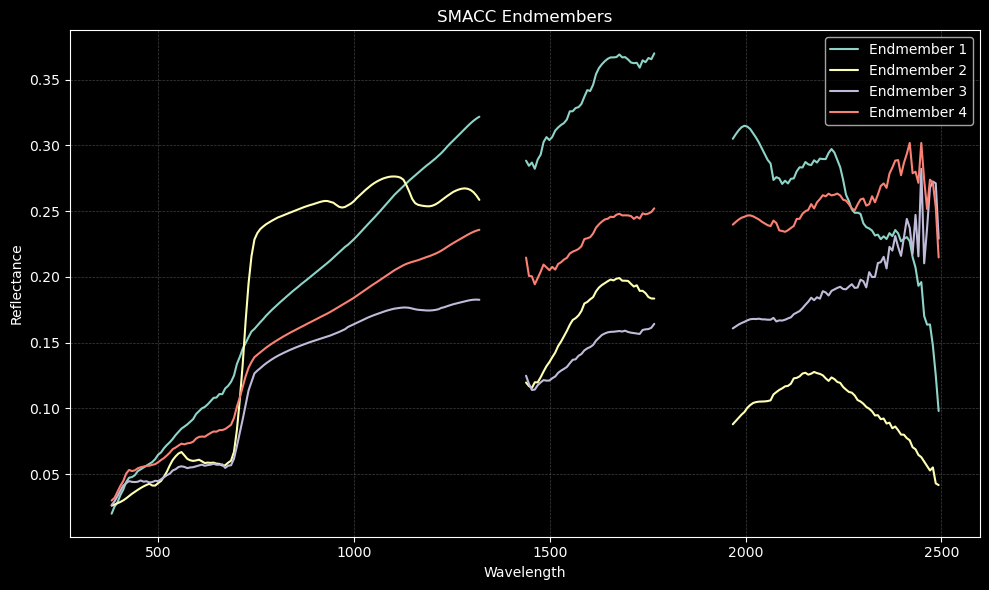

In [79]:
def smacc(spectra, min_endmembers=None, max_residual_norm=float('Inf')):
    '''Returns SMACC decomposition (H = F * S + R) matrices for an image or
    array of spectra.

    Let `H` be matrix of shape NxB, where B is number of bands, and N number of
    spectra, then if `spectra` is of the same shape, `H` will be equal to `spectra`.
    Otherwise, `spectra` is assumed to be 3D spectral image, and it is reshaped
    to match shape of `H`.

    Arguments:

        `spectra` (ndarray):

            Image data for which to calculate SMACC decomposition matrices.

        `min_endmembers` (int):

            Minimal number of endmembers to find. Defaults to rank of `H`,
            computed numerically with `numpy.linalg.matrix_rank`.

        `max_residual_norm`:

            Maximum value of residual vectors' norms. Algorithm will keep finding
            new endmembers until max value of residual norms is less than this
            argument. Defaults to float('Inf')

    Returns:
        3 matrices, S, F and R, such that H = F * S + R (but it might not always hold).
        F is matrix of expansion coefficients of shape N x num_endmembers.
        All values of F are equal to, or greater than zero.
        S is matrix of endmember spectra, extreme vectors, of shape num_endmembers x B.
        R is matrix of residuals of same shape as H (N x B).

        If values of H are large (few tousands), H = F * S + R, might not hold,
        because of numeric errors. It is advisable to scale numbers, by dividing
        by 10000, for example. Depending on how accurate you want it to be,
        you can check if H is really strictly equal to F * S + R,
        and adjust R: R = H - np.matmul(F, S).

    References:

        John H. Gruninger, Anthony J. Ratkowski, and Michael L. Hoke "The sequential
        maximum angle convex cone (SMACC) endmember model", Proc. SPIE 5425, Algorithms
        and Technologies for Multispectral, Hyperspectral, and Ultraspectral Imagery X,
        (12 August 2004); https://doi.org/10.1117/12.543794
    '''    
    # Flatten 3D spectral image to 2D if necessary
    H = spectra.reshape((-1, spectra.shape[2])) if spectra.ndim == 3 else spectra
    
    R = H.copy()
    Fs = []
    q = []  # Indices of selected vectors in S
    
    # Set default minimum endmembers
    if min_endmembers is None:
        min_endmembers = np.linalg.matrix_rank(H)

    residual_norms = np.linalg.norm(H, axis=1)
    current_max_residual_norm = np.max(residual_norms)
    
    if max_residual_norm is None:
        max_residual_norm = current_max_residual_norm / min_endmembers

    while len(q) < min_endmembers or current_max_residual_norm > max_residual_norm:
        idx = np.argmax(residual_norms)
        q.append(idx)
        
        # Calculate projection coefficients
        w = R[idx]
        wt = w / np.dot(w, w)
        On = np.dot(R, wt)
        alpha = np.ones_like(On)
        
        # Adjust alphas for oblique projection
        for k in range(len(Fs)):
            t = On * Fs[k][idx]
            t[t == 0.0] = 1e-10
            alpha = np.minimum(Fs[k] / t, alpha, where=t != 0.0)
        
        # Clip negative projection coefficients
        alpha[On <= 0.0] = 0.0
        alpha[idx] = 1.0
        
        # Calculate oblique projection coefficients
        Fn = alpha * On.clip(min=0.0)
        R -= np.outer(Fn, w)
        
        # Update existing factors
        for k in range(len(Fs)):
            Fs[k] -= Fs[k][idx] * Fn
            Fs[k] = Fs[k].clip(min=0.0)
        
        Fs.append(Fn)
        residual_norms = np.linalg.norm(R, axis=1)
        current_max_residual_norm = np.max(residual_norms)
        
        print(f'Found {len(q)} endmembers, current max residual norm is {current_max_residual_norm:.4f}\r', end='')

    # Correction as suggested in the SMACC paper.
    for k, s in enumerate(q):
        Fs[k][q] = 0.0
        Fs[k][s] = 1.0

    F = np.column_stack(Fs).T
    S = H[q]

    return S, F, R




# Use boolean indexing more efficiently by computing mask once
valid_bands = ~np.all(sampled_data < 0, axis=0)

# Get endmembers for valid bands only
S, F, R = smacc(sampled_data[:, valid_bands], min_endmembers=4, max_residual_norm=1)

# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

# Create figure
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    
    # Vectorized plotting using numpy operations
    wavelengths_matrix = np.tile(wavelengths, (endmembers.shape[0], 1)).T
    
    # Plot all lines at once with optimized line properties
    lines = ax.plot(wavelengths_matrix, endmembers.T, 
                   linewidth=1.5,  # Optimal line width for performance
                   solid_capstyle='round',
                   antialiased=True)
    
    ax.set_prop_cycle('color', plt.cm.tab10(np.linspace(0, 1, endmembers.shape[0])))
    
    ax.set(xlabel='Wavelength',
           ylabel='Reflectance',
           title='SMACC Endmembers')
    
    for text in (*ax.get_xticklabels(), *ax.get_yticklabels(),
                ax.xaxis.label, ax.yaxis.label, ax.title):
        text.set_color('white')
    
    ax.legend([f'Endmember {i+1}' for i in range(endmembers.shape[0])],
              framealpha=0.8,
              loc='best',
              ncol=1)

    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout()

### NFINDr

Cumulative PCA Explained Variance = [0.80891454 0.97141105 0.9898262  0.99337596]


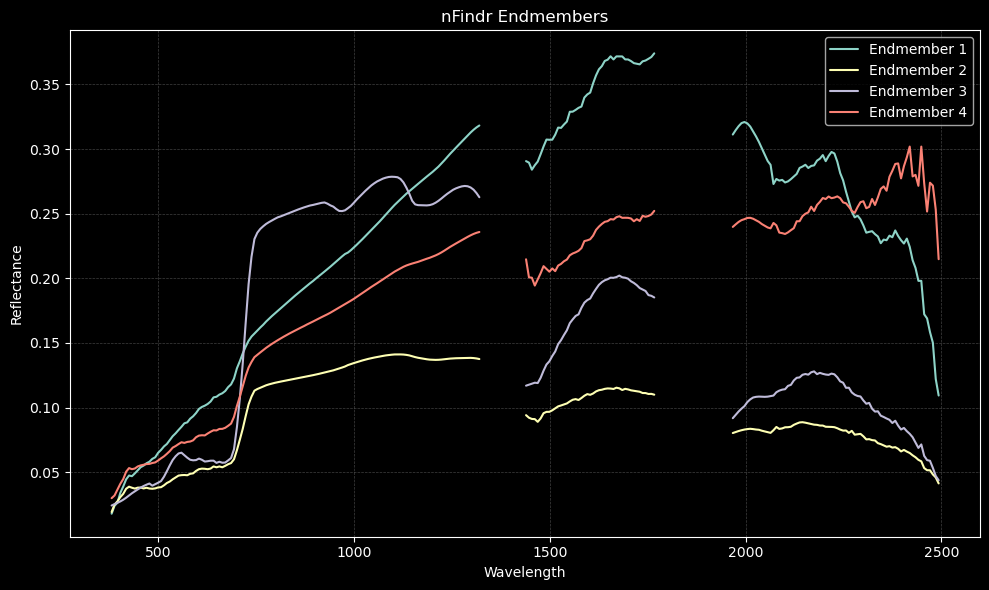

In [80]:

def nfindr(srData,n_components=0.99):
    """
    Extract endmembers from spectral data using the NFINDR algorithm.
    
    Parameters:
    - srData (ndarray): Input spectral reflectance data of shape (bands, samples).
    - nSubsets (int, optional): Number of subsets for subsampling. Defaults to None.
    
    Returns:
    - endmembers (ndarray): Detected endmember spectra.
    """

    # Compute the PCA
    pca = PCA(n_components=n_components)
    pcaData = pca.fit_transform(srData)
    
    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    print(f'Cumulative PCA Explained Variance = {cumulative_explained_variance}')
    
    # First two endmembers are the extremes of PCA component 1
    sub = np.array([np.argmax(pcaData[:, 0]), np.argmin(pcaData[:, 0])])

    # Loop to find remaining endmembers
    for nEdge in range(3, pcaData.shape[1] + 1):
        dmax = 0
        endMatrix = np.ones(nEdge)

        for i in range(nEdge - 1):
            endMatrix = np.vstack((endMatrix, np.append(pcaData[sub, i], 0)))

        # Test every pixel to find new endmember
        for i in range(len(pcaData)):
            endMatrix[1:nEdge, nEdge - 1] = pcaData[i, 0:nEdge - 1]
            
            # Calculate volume of the simplex
            volume = np.abs(np.linalg.det(endMatrix))
            
            if volume > dmax and i not in sub:
                dmax = volume
                subn = i
        
        print(f"Completed {nEdge} search\r", end='')
        sub = np.append(sub, subn)

    # Extract the endmembers in actual reflectance
    endmembers = srData[sub]
    return endmembers

# Use boolean indexing more efficiently by computing mask once
valid_bands = ~np.all(sampled_data < 0, axis=0)

# Get endmembers for valid bands only
S = nfindr(sampled_data[:, valid_bands], 0.99)

# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

# Create figure
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    
    # Vectorized plotting using numpy operations
    wavelengths_matrix = np.tile(wavelengths, (endmembers.shape[0], 1)).T
    
    # Plot all lines at once with optimized line properties
    lines = ax.plot(wavelengths_matrix, endmembers.T, 
                   linewidth=1.5,  # Optimal line width for performance
                   solid_capstyle='round',
                   antialiased=True)
    
    ax.set_prop_cycle('color', plt.cm.tab10(np.linspace(0, 1, endmembers.shape[0])))
    
    ax.set(xlabel='Wavelength',
           ylabel='Reflectance',
           title='nFindr Endmembers')
    
    for text in (*ax.get_xticklabels(), *ax.get_yticklabels(),
                ax.xaxis.label, ax.yaxis.label, ax.title):
        text.set_color('white')
    
    ax.legend([f'Endmember {i+1}' for i in range(endmembers.shape[0])],
              framealpha=0.8,
              loc='best',
              ncol=1)

    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout()





### QHULL

Cumulative PCA Explained Variance = [0.80891454 0.97141105 0.9898262 ]


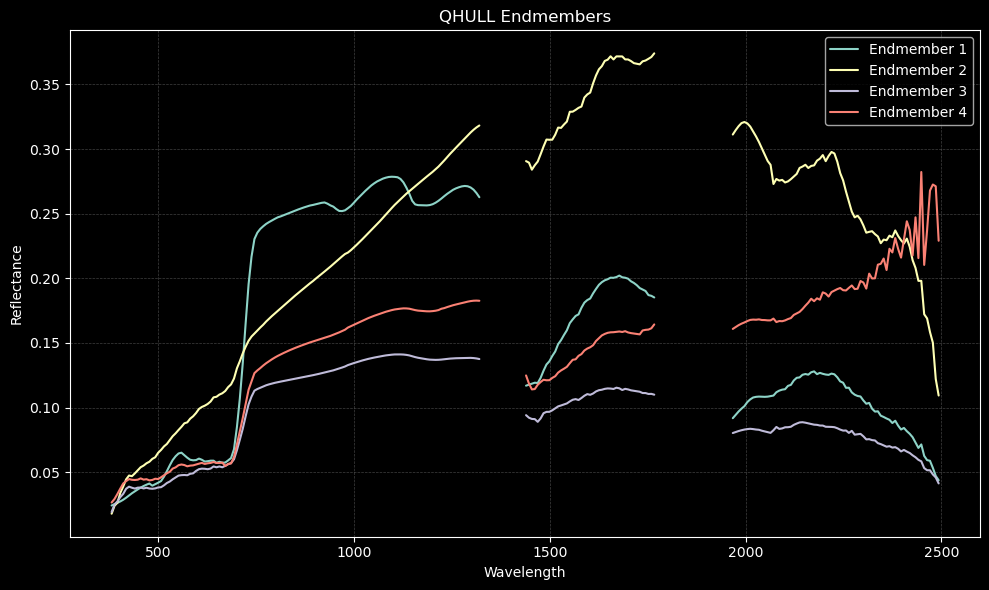

In [81]:
def qhull_endmembers(data,n_components=3):
    """
    Finds the edges of the data simplex using QHULL to find the endmembers.
    
    Parameters:
    data (numpy.ndarray): The input data, expected to be 2D (pixels x bands).
    subsize (int): The maximum number of pixels to use for the analysis.

    Returns:
    realsig (numpy.ndarray): The real signatures from the data.
    """


    # Perform PCA transformation
    pca = PCA(n_components=n_components)
    pc = pca.fit_transform(data)
    
    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    print(f'Cumulative PCA Explained Variance = {cumulative_explained_variance}')
    
    # Use Qhull via ConvexHull to find the extreme points
    # Fx print extreme points (vertices) of convex hulls
    # W0.1 min distance above plane for outside points to approximate the convex hull
    # QbB  - scale the input to fit the unit cube
    hull = ConvexHull(pc, qhull_options='Fx W0.5 QbB')

    # Extract the real signatures
    realsig = data[hull.vertices]


    return realsig

# Use boolean indexing more efficiently by computing mask once
valid_bands = ~np.all(sampled_data < 0, axis=0)

# Get endmembers for valid bands only
S = qhull_endmembers(sampled_data[:, valid_bands], 3)

# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

# Create figure
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    
    # Vectorized plotting using numpy operations
    wavelengths_matrix = np.tile(wavelengths, (endmembers.shape[0], 1)).T
    
    # Plot all lines at once with optimized line properties
    lines = ax.plot(wavelengths_matrix, endmembers.T, 
                   linewidth=1.5,  # Optimal line width for performance
                   solid_capstyle='round',
                   antialiased=True)
    
    ax.set_prop_cycle('color', plt.cm.tab10(np.linspace(0, 1, endmembers.shape[0])))
    
    ax.set(xlabel='Wavelength',
           ylabel='Reflectance',
           title='QHULL Endmembers')
    
    for text in (*ax.get_xticklabels(), *ax.get_yticklabels(),
                ax.xaxis.label, ax.yaxis.label, ax.title):
        text.set_color('white')
    
    ax.legend([f'Endmember {i+1}' for i in range(endmembers.shape[0])],
              framealpha=0.8,
              loc='best',
              ncol=1)

    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout()




## Get the set of all edges

In [2]:
import glob
import numpy as np
from netCDF4 import Dataset
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import os

def extract_and_mask_data(emit_file, mask_suffix='MASK'):
    """Load reflectance data and apply mask if available."""
    mask_file = emit_file.replace('RFL', mask_suffix)
    
    with Dataset(emit_file, 'r') as nc_ds:
        reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]
        rows, cols, bands = reflectance.shape
        wavelengths = np.array(nc_ds.groups['sensor_band_parameters']['wavelengths'][:])

        # Reshape to [pixels, bands]
        data = reflectance.reshape(-1, bands)

    if os.path.exists(mask_file):
        with Dataset(mask_file, 'r') as mask_ds:
            mask = mask_ds['mask'][:, :, 7].data.flatten() == 0
        data = data[mask]

    return data, wavelengths

def clean_data(data, max_reflectance_threshold=0.8):
    """Remove pixels with extreme values and identify bad bands."""
    valid_pixels = np.max(data, axis=1) < max_reflectance_threshold
    data = data[valid_pixels, :]

    # Identify and remove bands with completely negative values
    valid_bands = ~np.all(data < 0, axis=0)
    data = data[:, valid_bands]

    return data, valid_bands

def remove_outliers(data, contamination='auto', random_state=42):
    """Remove outliers using IsolationForest."""
    clf = IsolationForest(contamination=contamination, random_state=random_state)
    prediction = clf.fit_predict(data)
    return data[prediction == 1, :]

def qhull_endmembers(data, pca_components=3):
    """Extract endmembers via PCA and ConvexHull."""
    pca = PCA(n_components=pca_components, random_state=42)
    pc = pca.fit_transform(data)
    hull = ConvexHull(pc, qhull_options='Fx QbB')
    return data[hull.vertices, :]

# Main workflow
emit_files = glob.glob('/mnt/e/OneDrive - Cibo Labs Pty Ltd/smartsatQuality/**/EMIT_L2A_RFL_*.nc', recursive=True)
# Rempve any file with NZ_ in the name
emit_files = [f for f in emit_files if 'NZ_' not in f]
print(f'Found {len(emit_files)} EMIT files.')

all_endmembers = []

MIN_PIXELS = 1000000

# Loop through all files and extract edgemembers
for emit_file in emit_files:
    raw_data, wavelengths = extract_and_mask_data(emit_file)
    print(f'Extracted {raw_data.shape[0]} pixels from {os.path.basename(emit_file)}.')
    cleaned_data, valid_bands = clean_data(raw_data)  
    cleaned_data = remove_outliers(cleaned_data)
    print(f'Unmasked pixels: {cleaned_data.shape[0]}')
    if cleaned_data.shape[0] > MIN_PIXELS:
        endmembers = qhull_endmembers(cleaned_data)
        all_endmembers.append(endmembers)
        print(f'Extracted {endmembers.shape[0]} edgemembers from {os.path.basename(emit_file)}.')

# Concatenate all endmembers along the first axis
emit_data = np.vstack(all_endmembers)


# Save the results
np.save('emit_data3.npy', emit_data)
np.save('wavelengths.npy', wavelengths)
np.save('bad_bands.npy', valid_bands)

print("Final data shape:", emit_data.shape)

Found 82 EMIT files.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 2623104 pixels from EMIT_L2A_RFL_001_20240112T201143_2401213_006.nc.
Unmasked pixels: 2124571
Extracted 42 edgemembers from EMIT_L2A_RFL_001_20240112T201143_2401213_006.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1587236 pixels from EMIT_L2A_RFL_001_20240721T024222_2420301_008.nc.
Unmasked pixels: 1386745
Extracted 217 edgemembers from EMIT_L2A_RFL_001_20240721T024222_2420301_008.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1589760 pixels from EMIT_L2A_RFL_001_20241029T023511_2430302_055.nc.
Unmasked pixels: 1354311
Extracted 231 edgemembers from EMIT_L2A_RFL_001_20241029T023511_2430302_055.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1583993 pixels from EMIT_L2A_RFL_001_20230228T025805_2305902_008.nc.
Unmasked pixels: 1393756
Extracted 233 edgemembers from EMIT_L2A_RFL_001_20230228T025805_2305902_008.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1582933 pixels from EMIT_L2A_RFL_001_20230228T025817_2305902_009.nc.
Unmasked pixels: 1420489
Extracted 188 edgemembers from EMIT_L2A_RFL_001_20230228T025817_2305902_009.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1581168 pixels from EMIT_L2A_RFL_001_20230319T040531_2307802_010.nc.
Unmasked pixels: 1347041
Extracted 192 edgemembers from EMIT_L2A_RFL_001_20230319T040531_2307802_010.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1555979 pixels from EMIT_L2A_RFL_001_20230319T040543_2307802_011.nc.
Unmasked pixels: 1300420
Extracted 175 edgemembers from EMIT_L2A_RFL_001_20230319T040543_2307802_011.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1787199 pixels from EMIT_L2A_RFL_001_20230319T040555_2307802_012.nc.
Unmasked pixels: 1482525
Extracted 207 edgemembers from EMIT_L2A_RFL_001_20230319T040555_2307802_012.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1588768 pixels from EMIT_L2A_RFL_001_20240319T051258_2407903_022.nc.
Unmasked pixels: 1397924
Extracted 177 edgemembers from EMIT_L2A_RFL_001_20240319T051258_2407903_022.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1588776 pixels from EMIT_L2A_RFL_001_20240319T051310_2407903_023.nc.
Unmasked pixels: 1361366
Extracted 166 edgemembers from EMIT_L2A_RFL_001_20240319T051310_2407903_023.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1588774 pixels from EMIT_L2A_RFL_001_20240319T051322_2407903_024.nc.
Unmasked pixels: 1321559
Extracted 171 edgemembers from EMIT_L2A_RFL_001_20240319T051322_2407903_024.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1548521 pixels from EMIT_L2A_RFL_001_20240430T022527_2412102_044.nc.
Unmasked pixels: 1054182
Extracted 191 edgemembers from EMIT_L2A_RFL_001_20240430T022527_2412102_044.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1571935 pixels from EMIT_L2A_RFL_001_20240702T014147_2418401_057.nc.
Unmasked pixels: 1392386
Extracted 216 edgemembers from EMIT_L2A_RFL_001_20240702T014147_2418401_057.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1584737 pixels from EMIT_L2A_RFL_001_20240702T031400_2418402_018.nc.
Unmasked pixels: 1345893
Extracted 147 edgemembers from EMIT_L2A_RFL_001_20240702T031400_2418402_018.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1587131 pixels from EMIT_L2A_RFL_001_20240719T041722_2420102_016.nc.
Unmasked pixels: 1351870
Extracted 204 edgemembers from EMIT_L2A_RFL_001_20240719T041722_2420102_016.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1587151 pixels from EMIT_L2A_RFL_001_20240719T041734_2420102_017.nc.
Unmasked pixels: 1361328
Extracted 216 edgemembers from EMIT_L2A_RFL_001_20240719T041734_2420102_017.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1587222 pixels from EMIT_L2A_RFL_001_20240719T041746_2420102_018.nc.
Unmasked pixels: 1359634
Extracted 275 edgemembers from EMIT_L2A_RFL_001_20240719T041746_2420102_018.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1587737 pixels from EMIT_L2A_RFL_001_20240721T024210_2420301_007.nc.
Unmasked pixels: 1356641
Extracted 223 edgemembers from EMIT_L2A_RFL_001_20240721T024210_2420301_007.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1587236 pixels from EMIT_L2A_RFL_001_20240721T024222_2420301_008.nc.
Unmasked pixels: 1386745
Extracted 217 edgemembers from EMIT_L2A_RFL_001_20240721T024222_2420301_008.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1585126 pixels from EMIT_L2A_RFL_001_20240721T024234_2420301_009.nc.
Unmasked pixels: 1360106
Extracted 253 edgemembers from EMIT_L2A_RFL_001_20240721T024234_2420301_009.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1587143 pixels from EMIT_L2A_RFL_001_20240721T024246_2420301_010.nc.
Unmasked pixels: 1349564
Extracted 274 edgemembers from EMIT_L2A_RFL_001_20240721T024246_2420301_010.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1587500 pixels from EMIT_L2A_RFL_001_20240723T023937_2420501_002.nc.
Unmasked pixels: 1402412
Extracted 181 edgemembers from EMIT_L2A_RFL_001_20240723T023937_2420501_002.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1588530 pixels from EMIT_L2A_RFL_001_20240829T035230_2424202_044.nc.
Unmasked pixels: 1369039
Extracted 174 edgemembers from EMIT_L2A_RFL_001_20240829T035230_2424202_044.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1554145 pixels from EMIT_L2A_RFL_001_20240829T035242_2424202_045.nc.
Unmasked pixels: 1347440
Extracted 223 edgemembers from EMIT_L2A_RFL_001_20240829T035242_2424202_045.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1587384 pixels from EMIT_L2A_RFL_001_20240917T033336_2426102_018.nc.
Unmasked pixels: 1378493
Extracted 216 edgemembers from EMIT_L2A_RFL_001_20240917T033336_2426102_018.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1588209 pixels from EMIT_L2A_RFL_001_20240917T033348_2426102_019.nc.
Unmasked pixels: 1397529
Extracted 215 edgemembers from EMIT_L2A_RFL_001_20240917T033348_2426102_019.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1588660 pixels from EMIT_L2A_RFL_001_20240917T033400_2426102_020.nc.
Unmasked pixels: 1380657
Extracted 224 edgemembers from EMIT_L2A_RFL_001_20240917T033400_2426102_020.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1542381 pixels from EMIT_L2A_RFL_001_20240917T050621_2426103_015.nc.
Unmasked pixels: 1356460
Extracted 214 edgemembers from EMIT_L2A_RFL_001_20240917T050621_2426103_015.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1584503 pixels from EMIT_L2A_RFL_001_20240917T050633_2426103_016.nc.
Unmasked pixels: 1390847
Extracted 240 edgemembers from EMIT_L2A_RFL_001_20240917T050633_2426103_016.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1588521 pixels from EMIT_L2A_RFL_001_20240917T050645_2426103_017.nc.
Unmasked pixels: 1385434
Extracted 207 edgemembers from EMIT_L2A_RFL_001_20240917T050645_2426103_017.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1564528 pixels from EMIT_L2A_RFL_001_20240919T033329_2426302_014.nc.
Unmasked pixels: 1362155
Extracted 221 edgemembers from EMIT_L2A_RFL_001_20240919T033329_2426302_014.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1588886 pixels from EMIT_L2A_RFL_001_20241024T045843_2429803_062.nc.
Unmasked pixels: 1405931
Extracted 221 edgemembers from EMIT_L2A_RFL_001_20241024T045843_2429803_062.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1588850 pixels from EMIT_L2A_RFL_001_20241024T045855_2429803_063.nc.
Unmasked pixels: 1393860
Extracted 180 edgemembers from EMIT_L2A_RFL_001_20241024T045855_2429803_063.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1589464 pixels from EMIT_L2A_RFL_001_20241026T045451_2430003_042.nc.
Unmasked pixels: 1367316
Extracted 229 edgemembers from EMIT_L2A_RFL_001_20241026T045451_2430003_042.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1589443 pixels from EMIT_L2A_RFL_001_20241026T045503_2430003_043.nc.
Unmasked pixels: 1362409
Extracted 229 edgemembers from EMIT_L2A_RFL_001_20241026T045503_2430003_043.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1586090 pixels from EMIT_L2A_RFL_001_20241029T023523_2430302_056.nc.
Unmasked pixels: 1345321
Extracted 213 edgemembers from EMIT_L2A_RFL_001_20241029T023523_2430302_056.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1546192 pixels from EMIT_L2A_RFL_001_20241029T040708_2430303_016.nc.
Unmasked pixels: 1272921
Extracted 203 edgemembers from EMIT_L2A_RFL_001_20241029T040708_2430303_016.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1572958 pixels from EMIT_L2A_RFL_001_20241029T040720_2430303_017.nc.
Unmasked pixels: 1379542
Extracted 179 edgemembers from EMIT_L2A_RFL_001_20241029T040720_2430303_017.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1575082 pixels from EMIT_L2A_RFL_001_20241031T023034_2430502_046.nc.
Unmasked pixels: 1395615
Extracted 212 edgemembers from EMIT_L2A_RFL_001_20241031T023034_2430502_046.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1567430 pixels from EMIT_L2A_RFL_001_20241031T023046_2430502_047.nc.
Unmasked pixels: 1397248
Extracted 188 edgemembers from EMIT_L2A_RFL_001_20241031T023046_2430502_047.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1588913 pixels from EMIT_L2A_RFL_001_20241103T000222_2430715_024.nc.
Unmasked pixels: 1416828
Extracted 198 edgemembers from EMIT_L2A_RFL_001_20241103T000222_2430715_024.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1577646 pixels from EMIT_L2A_RFL_001_20241103T000234_2430715_025.nc.
Unmasked pixels: 1374599
Extracted 218 edgemembers from EMIT_L2A_RFL_001_20241103T000234_2430715_025.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1589596 pixels from EMIT_L2A_RFL_001_20250121T023722_2502101_013.nc.
Unmasked pixels: 1416011
Extracted 190 edgemembers from EMIT_L2A_RFL_001_20250121T023722_2502101_013.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1589612 pixels from EMIT_L2A_RFL_001_20250121T023734_2502101_014.nc.
Unmasked pixels: 1400111
Extracted 225 edgemembers from EMIT_L2A_RFL_001_20250121T023734_2502101_014.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1589628 pixels from EMIT_L2A_RFL_001_20250121T023746_2502101_015.nc.
Unmasked pixels: 1396887
Extracted 233 edgemembers from EMIT_L2A_RFL_001_20250121T023746_2502101_015.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1561739 pixels from EMIT_L2A_RFL_001_20250126T232232_2502615_006.nc.
Unmasked pixels: 1382020
Extracted 228 edgemembers from EMIT_L2A_RFL_001_20250126T232232_2502615_006.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 2040575 pixels from EMIT_L2A_RFL_001_20240101T010338_2400101_003.nc.
Unmasked pixels: 1759291
Extracted 165 edgemembers from EMIT_L2A_RFL_001_20240101T010338_2400101_003.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1330736 pixels from EMIT_L2A_RFL_001_20240106T001421_2400515_009.nc.
Unmasked pixels: 1150961
Extracted 259 edgemembers from EMIT_L2A_RFL_001_20240106T001421_2400515_009.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1412332 pixels from EMIT_L2A_RFL_001_20240106T050605_2400603_004.nc.
Unmasked pixels: 1168379
Extracted 233 edgemembers from EMIT_L2A_RFL_001_20240106T050605_2400603_004.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1430764 pixels from EMIT_L2A_RFL_001_20240107T223724_2400714_009.nc.
Unmasked pixels: 1162401
Extracted 209 edgemembers from EMIT_L2A_RFL_001_20240107T223724_2400714_009.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1280419 pixels from EMIT_L2A_RFL_001_20240225T041553_2405603_045.nc.
Unmasked pixels: 1057375
Extracted 237 edgemembers from EMIT_L2A_RFL_001_20240225T041553_2405603_045.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1472023 pixels from EMIT_L2A_RFL_001_20240229T024124_2406002_035.nc.
Unmasked pixels: 1247028
Extracted 218 edgemembers from EMIT_L2A_RFL_001_20240229T024124_2406002_035.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1581485 pixels from EMIT_L2A_RFL_001_20240229T024135_2406002_036.nc.
Unmasked pixels: 1353263
Extracted 231 edgemembers from EMIT_L2A_RFL_001_20240229T024135_2406002_036.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1184623 pixels from EMIT_L2A_RFL_001_20240307T233047_2406715_025.nc.
Unmasked pixels: 999820


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1531852 pixels from EMIT_L2A_RFL_001_20240307T233058_2406715_026.nc.
Unmasked pixels: 1275619
Extracted 215 edgemembers from EMIT_L2A_RFL_001_20240307T233058_2406715_026.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1510540 pixels from EMIT_L2A_RFL_001_20240307T233110_2406715_027.nc.
Unmasked pixels: 1251597
Extracted 201 edgemembers from EMIT_L2A_RFL_001_20240307T233110_2406715_027.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1321160 pixels from EMIT_L2A_RFL_001_20240319T233816_2407915_006.nc.
Unmasked pixels: 1138231
Extracted 207 edgemembers from EMIT_L2A_RFL_001_20240319T233816_2407915_006.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1485758 pixels from EMIT_L2A_RFL_001_20240904T223036_2424814_013.nc.
Unmasked pixels: 1296429
Extracted 182 edgemembers from EMIT_L2A_RFL_001_20240904T223036_2424814_013.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1495223 pixels from EMIT_L2A_RFL_001_20240904T223047_2424814_014.nc.
Unmasked pixels: 1277926
Extracted 166 edgemembers from EMIT_L2A_RFL_001_20240904T223047_2424814_014.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1589760 pixels from EMIT_L2A_RFL_001_20241029T023511_2430302_055.nc.
Unmasked pixels: 1354311
Extracted 231 edgemembers from EMIT_L2A_RFL_001_20241029T023511_2430302_055.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1378232 pixels from EMIT_L2A_RFL_001_20241101T232352_2430615_024.nc.
Unmasked pixels: 1095630
Extracted 125 edgemembers from EMIT_L2A_RFL_001_20241101T232352_2430615_024.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 2070929 pixels from EMIT_L2A_RFL_001_20241103T232146_2430815_032.nc.
Unmasked pixels: 1692115
Extracted 234 edgemembers from EMIT_L2A_RFL_001_20241103T232146_2430815_032.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1405485 pixels from EMIT_L2A_RFL_001_20241106T041031_2431102_004.nc.
Unmasked pixels: 1169585
Extracted 207 edgemembers from EMIT_L2A_RFL_001_20241106T041031_2431102_004.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1355954 pixels from EMIT_L2A_RFL_001_20241106T223004_2431114_033.nc.
Unmasked pixels: 1144809
Extracted 257 edgemembers from EMIT_L2A_RFL_001_20241106T223004_2431114_033.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1214383 pixels from EMIT_L2A_RFL_001_20241113T013641_2431801_007.nc.
Unmasked pixels: 1040167
Extracted 216 edgemembers from EMIT_L2A_RFL_001_20241113T013641_2431801_007.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1225068 pixels from EMIT_L2A_RFL_001_20241113T013653_2431801_008.nc.
Unmasked pixels: 1052053
Extracted 236 edgemembers from EMIT_L2A_RFL_001_20241113T013653_2431801_008.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1257399 pixels from EMIT_L2A_RFL_001_20241116T235938_2432115_005.nc.
Unmasked pixels: 1070493
Extracted 213 edgemembers from EMIT_L2A_RFL_001_20241116T235938_2432115_005.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1347992 pixels from EMIT_L2A_RFL_001_20241116T235949_2432115_006.nc.
Unmasked pixels: 1177789
Extracted 232 edgemembers from EMIT_L2A_RFL_001_20241116T235949_2432115_006.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1438211 pixels from EMIT_L2A_RFL_001_20241228T011342_2436301_017.nc.
Unmasked pixels: 1083695
Extracted 138 edgemembers from EMIT_L2A_RFL_001_20241228T011342_2436301_017.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1579397 pixels from EMIT_L2A_RFL_001_20241228T011354_2436301_018.nc.
Unmasked pixels: 1209572
Extracted 136 edgemembers from EMIT_L2A_RFL_001_20241228T011354_2436301_018.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1573138 pixels from EMIT_L2A_RFL_001_20241228T011405_2436301_019.nc.
Unmasked pixels: 1125602
Extracted 118 edgemembers from EMIT_L2A_RFL_001_20241228T011405_2436301_019.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1343357 pixels from EMIT_L2A_RFL_001_20241228T011417_2436301_020.nc.
Unmasked pixels: 957287


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1271302 pixels from EMIT_L2A_RFL_001_20250101T011158_2500101_063.nc.
Unmasked pixels: 1043279
Extracted 90 edgemembers from EMIT_L2A_RFL_001_20250101T011158_2500101_063.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1452870 pixels from EMIT_L2A_RFL_001_20250104T233254_2500415_046.nc.
Unmasked pixels: 1228237
Extracted 259 edgemembers from EMIT_L2A_RFL_001_20250104T233254_2500415_046.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1545365 pixels from EMIT_L2A_RFL_001_20250105T224404_2500515_032.nc.
Unmasked pixels: 1314015
Extracted 245 edgemembers from EMIT_L2A_RFL_001_20250105T224404_2500515_032.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1585944 pixels from EMIT_L2A_RFL_001_20231022T055225_2329504_045.nc.
Unmasked pixels: 1348219
Extracted 213 edgemembers from EMIT_L2A_RFL_001_20231022T055225_2329504_045.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1585896 pixels from EMIT_L2A_RFL_001_20231022T055237_2329504_046.nc.
Unmasked pixels: 1373061
Extracted 190 edgemembers from EMIT_L2A_RFL_001_20231022T055237_2329504_046.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1585804 pixels from EMIT_L2A_RFL_001_20231022T055248_2329504_047.nc.
Unmasked pixels: 1359843
Extracted 194 edgemembers from EMIT_L2A_RFL_001_20231022T055248_2329504_047.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1585478 pixels from EMIT_L2A_RFL_001_20231022T055300_2329504_048.nc.
Unmasked pixels: 1366770
Extracted 212 edgemembers from EMIT_L2A_RFL_001_20231022T055300_2329504_048.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1543707 pixels from EMIT_L2A_RFL_001_20231026T041710_2329903_030.nc.
Unmasked pixels: 1296142
Extracted 213 edgemembers from EMIT_L2A_RFL_001_20231026T041710_2329903_030.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1587530 pixels from EMIT_L2A_RFL_001_20231030T024137_2330302_025.nc.
Unmasked pixels: 1371326
Extracted 235 edgemembers from EMIT_L2A_RFL_001_20231030T024137_2330302_025.nc.


/tmp/ipykernel_4264/2005451346.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  reflectance = np.array(nc_ds['reflectance'])  # shape: [rows, cols, bands]


Extracted 1580764 pixels from EMIT_L2A_RFL_001_20231103T010500_2330701_022.nc.
Unmasked pixels: 1373779
Extracted 207 edgemembers from EMIT_L2A_RFL_001_20231103T010500_2330701_022.nc.
Final data shape: (16400, 244)


Found 66 edge members with w=0.01
Starting with 66 edge members.
Starting optimization to find a convex hull with 6 vertices...
differential_evolution step 1: f(x)= 865.6581634563347
differential_evolution step 2: f(x)= 738.1965284363715
differential_evolution step 3: f(x)= 738.1965284363715
differential_evolution step 4: f(x)= 686.6440072980024
differential_evolution step 5: f(x)= 686.6440072980024
differential_evolution step 6: f(x)= 686.6440072980024
differential_evolution step 7: f(x)= 686.6440072980024
differential_evolution step 8: f(x)= 686.6440072980024
differential_evolution step 9: f(x)= 686.6440072980024
differential_evolution step 10: f(x)= 686.6440072980024
differential_evolution step 11: f(x)= 591.8024410908757
differential_evolution step 12: f(x)= 591.8024410908757
differential_evolution step 13: f(x)= 591.8024410908757
differential_evolution step 14: f(x)= 591.8024410908757
differential_evolution step 15: f(x)= 591.8024410908757
differential_evolution step 16: f(x)= 591

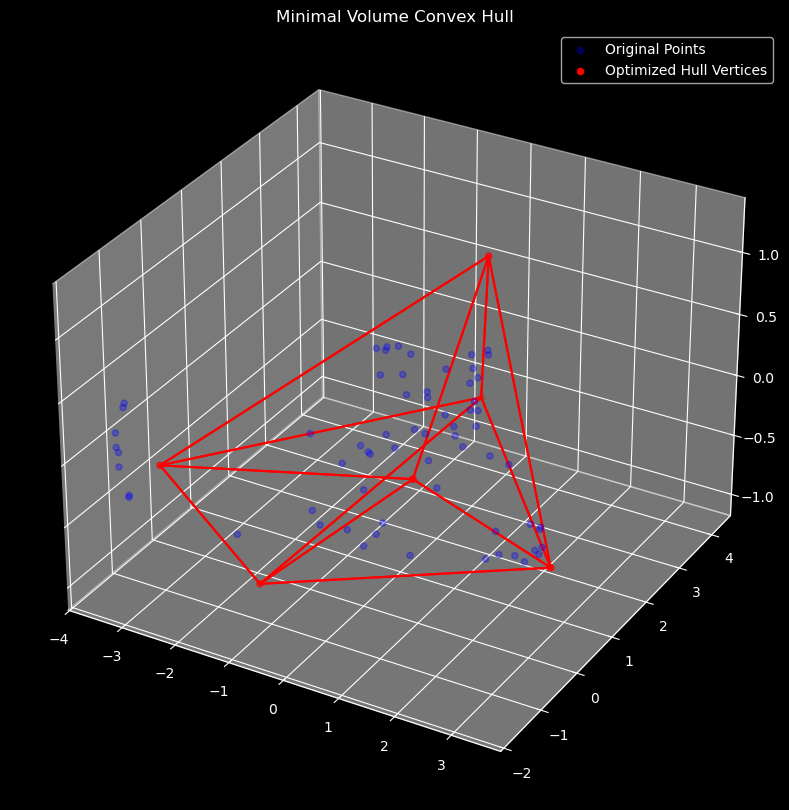

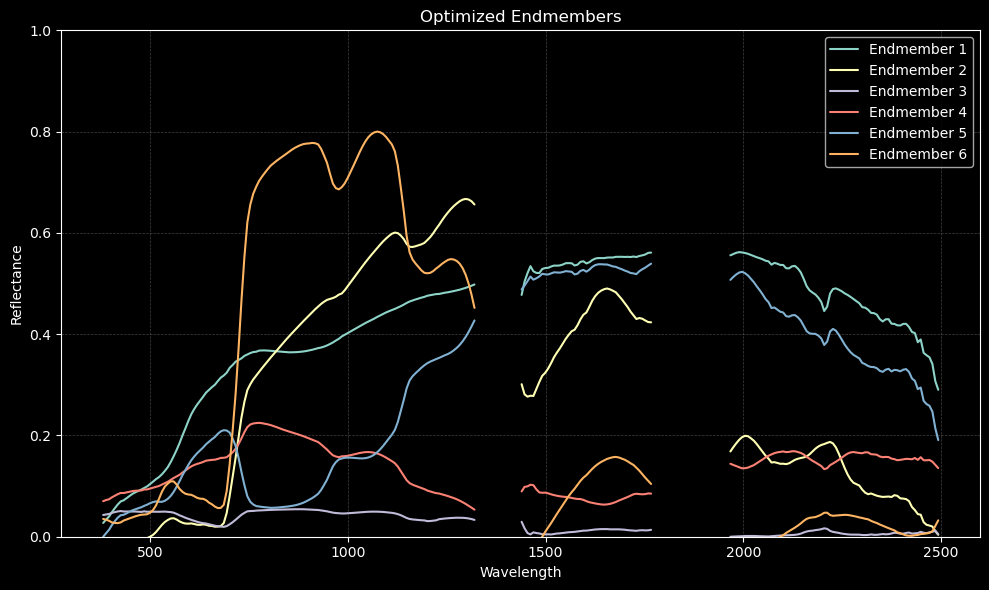

In [6]:
#%matplotlib widget
%matplotlib inline
"""
Minimal Volume Convex Hull Optimization in 3D

This script finds a minimal-volume convex hull with N vertices that encloses
a given set of 3D points using global optimization (Differential Evolution).

Author: Peter Scarth
Date: 2025-02-18
"""
import joblib
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull, Delaunay
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plotting

def compute_hull_volume(points):
    """
    Compute the volume of the convex hull of given points.

    Parameters:
    - points: ndarray of shape (M, 3).

    Returns:
    - volume: float, volume of the convex hull. Returns np.inf if hull computation fails.
    """
    try:
        hull = ConvexHull(points)
        return hull.volume
    except:
        # If points are coplanar or otherwise degenerate
        return np.inf

def points_inside_hull(original_points, hull_vertices):
    """
    Check which original points are inside the convex hull defined by hull_vertices.

    Parameters:
    - original_points: ndarray of shape (M, 3), points to check.
    - hull_vertices: ndarray of shape (N, 3), vertices of the convex hull.

    Returns:
    - inside: ndarray of shape (M,), boolean array indicating whether each point is inside the hull.
    """
    try:
        delaunay = Delaunay(hull_vertices)
        return delaunay.find_simplex(original_points) >= 0
    except:
        # If the Delaunay triangulation fails (e.g., degenerate hull)
        return np.zeros(len(original_points), dtype=bool)

def define_bounds(original_points, N, padding=1.0):
    """
    Define the bounds for each coordinate of the N new vertices based on the original data.

    Parameters:
    - original_points: ndarray of shape (M, 3), original data points.
    - N: int, number of vertices for the new convex hull.
    - padding: float, extra space added to the bounds.

    Returns:
    - bounds: list of tuples, bounds for each variable in the optimizer.
    """
    mins = original_points.min(axis=0) - padding
    maxs = original_points.max(axis=0) + padding
    bounds = []
    for _ in range(N):
        for dim in range(3):
            bounds.append((mins[dim], maxs[dim]))
    return bounds



def objective(global_variables, original_points, N, penalty_weight=10, pca=None, bound_penalty_weight=1, max_reflectance=1):
    """
    Objective function to minimize: volume of the convex hull + penalties for points outside +
    penalties for inverse-transformed endmembers outside [0, 1].

    Parameters:
    - global_variables: ndarray of shape (3N,), flattened coordinates of N vertices.
    - original_points: ndarray of shape (M, 3), points to be enclosed.
    - N: int, number of vertices for the new convex hull.
    - penalty_weight: float, weight for the penalty term for points outside.
    - pca: PCA object, used for inverse transformation.
    - bound_penalty_weight: float, weight for the penalty term for bound violations.
    - max_reflectance: float, maximum reflectance value for bound violations.

    Returns:
    - total_cost: float, sum of hull volume and penalties.
    """
    # Reshape the variable vector into N x 3 points
    Q = global_variables.reshape((N, 3))
    
    try:
        hull = ConvexHull(Q)
        volume = hull.volume
    except:
        # Assign a large volume if hull computation fails
        return 1e12
    
    # Retrieve the hull vertices for Delaunay triangulation
    hull_vertices = Q[hull.vertices]
    
    # Check which original points are inside the hull
    inside = points_inside_hull(original_points, hull_vertices)
    num_outside = np.size(inside) - np.sum(inside)
    
    # Calculate penalty for points outside
    penalty = penalty_weight * num_outside
    
    # Additional penalty for inverse-transformed endmembers outside [0, Max Reflectance]
    if pca is not None:
        try:
            # Inverse transform to original space
            endmembers = pca.inverse_transform(Q)
            
            # Compute violations: any value <0 or >0.5
            violations = np.sum((endmembers < 0) | (endmembers > max_reflectance))
            
            # Apply penalty for each violation
            penalty += bound_penalty_weight * violations
        except Exception as e:
            # If inverse_transform fails, apply a large penalty
            penalty += 1e6
    
    # Total cost is volume plus penalties
    total_cost = volume + penalty
    
    return total_cost

def find_minimal_convex_hull_global(original_points, N, pca, penalty_weight=10, bound_penalty_weight=1, maxiter=1000, popsize=15, seed=None, max_reflectance=1):
    """
    Find the minimal-volume convex hull enclosing the original points using Differential Evolution.

    Parameters:
    - original_points: ndarray of shape (M, 3), points to enclose.
    - N: int, number of vertices for the new convex hull (must be >=4 for 3D).
    - pca: PCA object, used for inverse transformation.
    - penalty_weight: float, weight for the penalty term for points outside.
    - bound_penalty_weight: float, weight for the penalty term for bound violations.
    - maxiter: int, maximum number of iterations for the optimizer.
    - popsize: int, population size multiplier (default 15).
    - seed: int or None, random seed for reproducibility.

    Returns:
    - optimized_vertices: ndarray of shape (N, 3), optimized positions of hull vertices.
    - result: OptimizeResult object, contains information about the optimization.
    """
    if N < 4:
        raise ValueError("N must be at least 4 to form a 3D convex hull.")
    
    # Define bounds for the optimizer
    bounds = define_bounds(original_points, N, padding=1.0)
    
    # Perform Differential Evolution
    result = differential_evolution(
        func=objective,
        bounds=bounds,
        args=(original_points, N, penalty_weight, pca, bound_penalty_weight, max_reflectance),
        strategy='best1bin',
        maxiter=maxiter,
        popsize=popsize,
        tol=1e-6,
        mutation=(0.5, 1),
        recombination=0.7,
        seed=seed,
        disp=True,
        polish=True,
        init='latinhypercube',
        updating='deferred',  # Improves performance by deferring updates
        workers=1  # Use all available CPU cores
    )
    
    # Extract optimized vertices
    optimized_vertices = result.x.reshape((N, 3))
    return optimized_vertices, result

def plot_convex_hull(original_points, hull_vertices, title='Minimal Volume Convex Hull'):
    """
    Plot the original points and the optimized convex hull in 3D.

    Parameters:
    - original_points: ndarray of shape (M, 3), original data points.
    - hull_vertices: ndarray of shape (N, 3), vertices of the optimized convex hull.
    - title: str, title of the plot.
    """
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot original points
    ax.scatter(original_points[:,0], original_points[:,1], original_points[:,2],
               color='blue', alpha=0.3, label='Original Points')
    
    # Compute convex hull of optimized vertices
    try:
        hull = ConvexHull(hull_vertices)
        for simplex in hull.simplices:
            simplex = np.append(simplex, simplex[0])  # To create a closed loop
            ax.plot(hull_vertices[simplex, 0], hull_vertices[simplex, 1], hull_vertices[simplex, 2],
                    'r-')
        
        # Optionally, plot the vertices
        ax.scatter(hull_vertices[:,0], hull_vertices[:,1], hull_vertices[:,2],
                   color='red', label='Optimized Hull Vertices')
    except Exception as e:
        print("Failed to compute convex hull for visualization:", e)
    
    ax.set_title(title)
    ax.legend()
    
    plt.show()

def plot_endmembers(wavelengths, endmembers, title = ''):
    """
    Plot endmember spectra with wavelengths.
    
    Parameters:
    - wavelengths: ndarray of shape (n_bands,), wavelength values
    - endmembers: ndarray of shape (n_endmembers, n_bands), endmember spectra
    """
    with plt.style.context('dark_background'):
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        
        # Vectorized plotting using numpy operations
        wavelengths_matrix = np.tile(wavelengths, (endmembers.shape[0], 1)).T
        
        # Plot all lines at once with optimized line properties
        lines = ax.plot(wavelengths_matrix, endmembers.T, 
                       linewidth=1.5,  # Optimal line width for performance
                       solid_capstyle='round',
                       antialiased=True)
        
        ax.set_prop_cycle('color', plt.cm.tab10(np.linspace(0, 1, endmembers.shape[0])))
        
        ax.set(xlabel='Wavelength',
               ylabel='Reflectance',
               title=title)
        
        for text in (*ax.get_xticklabels(), *ax.get_yticklabels(),
                    ax.xaxis.label, ax.yaxis.label, ax.title):
            text.set_color('white')
        
        ax.legend([f'Endmember {i+1}' for i in range(endmembers.shape[0])],
                  framealpha=0.8,
                  loc='best',
                  ncol=1)

        ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        # Set the y range to [0, 1]
        ax.set_ylim(0, 1)
        fig.tight_layout()


# Load the data
emit_sample = np.load('emit_data3.npy')
wavelengths = np.load('wavelengths.npy')
valid_bands = np.load('valid_bands.npy')
sampled_data = np.full((emit_sample.shape[0], len(wavelengths)), -1.0, dtype=np.float32)
sampled_data[:, valid_bands] = emit_sample

# Find the edgemembers
valid_bands = ~np.all(sampled_data < 0, axis=0)
pca = PCA(n_components=3)
pc = pca.fit_transform(sampled_data[:, valid_bands])

# Get at least start_vertices edge members
start_vertices = 50
w_val=0.5
num_vertices = 4
while num_vertices < start_vertices:
    w_val -= 0.005
    hull = ConvexHull(pc, qhull_options=f'Fx W{w_val} QbB')
    num_vertices = len(hull.vertices)
    

print(f"Found {num_vertices} edge members with w={w_val:.2f}")
edgemembers = pc[hull.vertices]
print(f"Starting with {len(edgemembers)} edge members.")

# Parameters
N = 6 # Number of vertices for the new convex hull (>=4)
penalty_weight = 20.0 # Penalty for points outside the hull
bound_penalty_weight = 1.0 # Penalty for inverse-transformed endmembers outside [0, 1]   
max_reflectance = 0.8 # Maximum reflectance value for bound violations   
maxiter = 100000000 # Maximum number of iterations for the optimizer
popsize = 15 # Population size multiplier
seed = None # Random seed for reproducibility

# Find minimal convex hull using global optimizer
print(f"Starting optimization to find a convex hull with {N} vertices...")
optimized_vertices, optimization_result = find_minimal_convex_hull_global(
    edgemembers,
    N=N,
    pca=pca,
    penalty_weight=penalty_weight,
    bound_penalty_weight=bound_penalty_weight,
    maxiter=maxiter,
    popsize=popsize,
    seed=seed,
    max_reflectance=max_reflectance
)

# Display optimization results
print("\nOptimization Results:")
print(f"Success: {optimization_result.success}")
print(f"Message: {optimization_result.message}")
print(f"Number of Function Evaluations: {optimization_result.nfev}")
final_volume = compute_hull_volume(optimized_vertices)
print(f"Final Volume of Optimized Convex Hull: {final_volume:.4f}")

# Verify that all points are inside the optimized hull
try:
    hull = ConvexHull(optimized_vertices)
    hull_vertices = optimized_vertices[hull.vertices]
    inside = points_inside_hull(edgemembers, hull_vertices)
    num_inside = np.sum(inside)
    print(f"Number of Original Points Inside the Optimized Hull: {num_inside} / {len(edgemembers)}")
except Exception as e:
    print("Failed to verify point enclosure:", e)

# Plot the results
plot_convex_hull(edgemembers, optimized_vertices, title='Minimal Volume Convex Hull')

    

# Use the inverse PCA transformation to get the endmembers in the original space
S = pca.inverse_transform(hull_vertices)
# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

plot_endmembers(wavelengths, endmembers, title='Optimized Endmembers')



# Save the PCA, the optimized vertices, and the endmembers
joblib.dump(pca, 'pca.joblib')
np.save('optimized_vertices6.npy', optimized_vertices)
np.save('endmembers6.npy', endmembers)
np.save('edgemembers6.npy', edgemembers)





(7, 285)

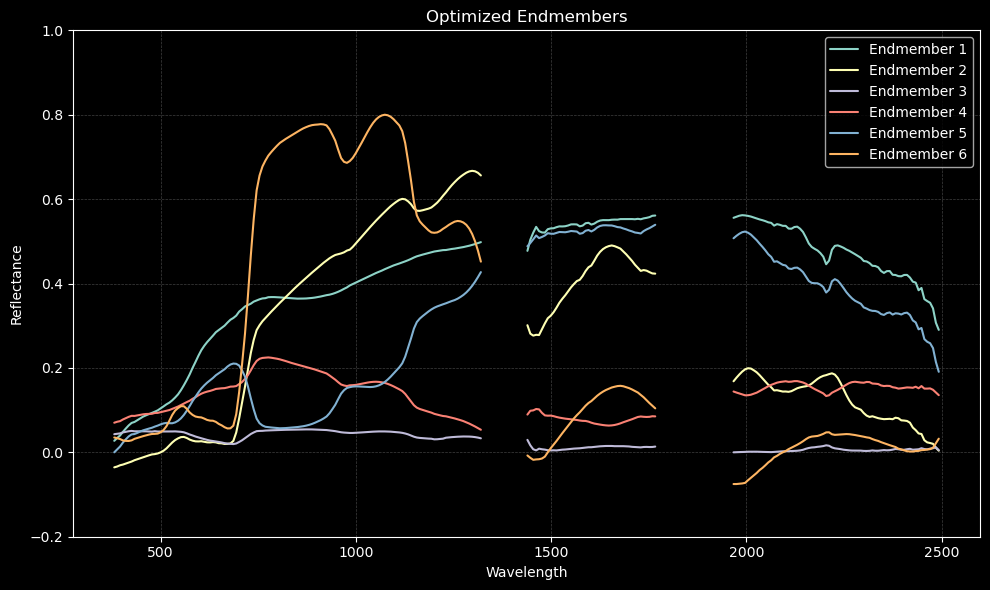

In [7]:
def plot_endmembers(wavelengths, endmembers, title = ''):
    """
    Plot endmember spectra with wavelengths.
    
    Parameters:
    - wavelengths: ndarray of shape (n_bands,), wavelength values
    - endmembers: ndarray of shape (n_endmembers, n_bands), endmember spectra
    """
    with plt.style.context('dark_background'):
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        
        # Vectorized plotting using numpy operations
        wavelengths_matrix = np.tile(wavelengths, (endmembers.shape[0], 1)).T
        
        # Plot all lines at once with optimized line properties
        lines = ax.plot(wavelengths_matrix, endmembers.T, 
                       linewidth=1.5,  # Optimal line width for performance
                       solid_capstyle='round',
                       antialiased=True)
        
        ax.set_prop_cycle('color', plt.cm.tab10(np.linspace(0, 1, endmembers.shape[0])))
        
        ax.set(xlabel='Wavelength',
               ylabel='Reflectance',
               title=title)
        
        for text in (*ax.get_xticklabels(), *ax.get_yticklabels(),
                    ax.xaxis.label, ax.yaxis.label, ax.title):
            text.set_color('white')
        
        ax.legend([f'Endmember {i+1}' for i in range(endmembers.shape[0])],
                  framealpha=0.8,
                  loc='best',
                  ncol=1)

        ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        # Set the y range to [0, 1]
        ax.set_ylim(-0.2, 1)
        fig.tight_layout()


# Load the data
emit_sample = np.load('emit_data.npy')
wavelengths = np.load('wavelengths.npy')
valid_bands = np.load('valid_bands.npy')
endmembers = np.load('endmembers6.npy')

plot_endmembers(wavelengths, endmembers, title='Optimized Endmembers')

1 - Dry
2 - Dry (litter)
3 - Bare??
4 - Shade/Water


# Unmixing

In [10]:
import numpy as np
from rios import applier
from rios import fileinfo
from rios import cuiprogress
from scipy.optimize import nnls
import matplotlib.pyplot as plt
from osgeo import gdal
import os
import joblib


gdal.UseExceptions()

base_dir = '/mnt/e/OneDrive - Cibo Labs Pty Ltd/smartsatQuality/'
# The paths to the input and output files
refDataPath = 'EMIT_L2A_RFL_001_20240721T024222_2420301_008_reflectance.tif'
unmixDataPath = 'EMIT_L2A_RFL_001_20240721T024222_2420301_008_unmixedall6.tif'

refDataPath = os.path.join(base_dir, refDataPath)
unmixDataPath = os.path.join(base_dir, unmixDataPath)



def _nnls_unmix(info, inputs, outputs, otherargs):
    nbar = inputs.nbar[otherargs.valid_bands]
    mask = np.all(nbar == otherargs.noData, axis=0)

    # Flatten reflectance and perform PCA in one step to save memory
    original_shape = nbar.shape
    nbar_transformed = otherargs.pca.transform(nbar.reshape(original_shape[0], -1).T).T

    # Precompute ones array outside the loop
    ones_array = np.full((1, nbar_transformed.shape[1]), otherargs.sum_to_one)

    # Combine weighted reflectance with ones_array using np.vstack
    weightedReflectance = np.vstack((nbar_transformed, ones_array))

    # Initialize fractions array with zeros
    fractions = np.zeros((otherargs.weighted_endmembers.shape[1], nbar_transformed.shape[1]), dtype=np.float32)

    # Use vectorization where possible
    for i in range(weightedReflectance.shape[1]):
        fractions[:, i], _ = nnls(otherargs.weighted_endmembers, weightedReflectance[:, i])

    # Reshape, clip, and convert to 8-bit data
    fractions = np.clip(np.rint(100.0 * fractions.reshape((-1,original_shape[1], original_shape[2]))), 0, 200).astype('uint8')

    # Compute fractions for bare, green, dry vegetation
    fractions_bgd = np.zeros((3, original_shape[1], original_shape[2]), dtype=np.uint8)
    fractions_bgd[0] = fractions[otherargs.bare_green_dry[0]].sum(axis=0)
    fractions_bgd[1] = fractions[otherargs.bare_green_dry[1]].sum(axis=0)
    fractions_bgd[2] = fractions[otherargs.bare_green_dry[2]].sum(axis=0)

    # Apply mask
    fractions_bgd[:, mask] = 255
    fractions[:, mask] = 255

    # Write the output
    outputs.fractions = fractions
    outputs.fractions_bgd = fractions_bgd



# Setup inputs, outputs, and other configurations
sum_to_one = 1
pca = joblib.load('pca.joblib')
optimized_vertices = np.load('optimized_vertices6.npy')
valid_bands = np.load('valid_bands.npy')



weighted_endmembers = np.vstack((optimized_vertices.T, np.ones(optimized_vertices.shape[0]) * sum_to_one))
bare_green_dry = [[7,5], [2,3,8], [1,4,6]] # Bare, green, dry endmember mapping 8
bare_green_dry = [[1,4], [3,6], [2,5]] # Bare, green, dry endmember mapping
# Cnvert to 0-based index
bare_green_dry = [[int(band)-1 for band in fraction] for fraction in bare_green_dry]

infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()
infiles.nbar = refDataPath
outfiles.fractions = unmixDataPath
outfiles.fractions_bgd = unmixDataPath.replace('.tif', '_bgd.tif')

otherargs = applier.OtherInputs()
otherargs.noData = fileinfo.ImageInfo(infiles.nbar).nodataval[0]
otherargs.pca = pca
otherargs.weighted_endmembers = weighted_endmembers
otherargs.valid_bands = valid_bands
otherargs.sum_to_one = sum_to_one
otherargs.bare_green_dry = bare_green_dry

controls = applier.ApplierControls()
controls.windowxsize = controls.windowysize = 512
controls.progress = cuiprogress.CUIProgressBar()
controls.setStatsIgnore(255)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions([
    "COMPRESS=DEFLATE",
    "ZLEVEL=1",
    "BIGTIFF=YES",
    "TILED=YES",
    "INTERLEAVE=BAND",
    "NUM_THREADS=ALL_CPUS",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512"
])

rtn = applier.apply(_nnls_unmix, infiles, outfiles, otherargs, controls=controls)


## Samping EMIT and ENMAP

In [ ]:
def getBandDescriptions(rasterName):
    """
    Get the band descriptions from the raster metadata.
    """
    ds = gdal.Open(rasterName)
    band_descriptions = []
    for i in range(1, ds.RasterCount + 1):
        band = ds.GetRasterBand(i)
        band_descriptions.append(band.GetDescription())
    return band_descriptions





def getPixelSample(info, inputs, outputs, otherargs):
    """
    Helper Function. Called from RIOS and randomly subsamples
     the data to about SUBSAMPLE pixels
    """
    enmap = inputs.enmap
    emit = inputs.emit
    emit = emit.reshape((emit.shape[0],-1)).T
    enmap = enmap.reshape((enmap.shape[0],-1)).T
    # Get the nodata id emit or enmap is nodata
    nodata = np.all(emit == 0, axis=1) | np.all(enmap == -32768, axis=1)
    emit = emit[~nodata]
    enmap = enmap[~nodata]
    numSamples = len(emit)
    if numSamples > 0:
        # choose a random subset of the data based on how much data
        # in this block
        emit_sample = emit[np.random.choice(numSamples, size=int(numSamples / otherargs.sampleFraction), replace=False)]
        enmap_sample = enmap[np.random.choice(numSamples, size=int(numSamples / otherargs.sampleFraction), replace=False)]
        otherargs.emitsample.append(emit_sample)
        otherargs.enmapsample.append(enmap_sample)


def subSampleRaster(emitName, enmapName, subsample):
    """
    Samples about SUBSAMPLE pixels from the given raster
    Using the getPixelSample funtion in RIOS
    """
    # Use fileinfo
    raster_info = fileinfo.ImageInfo(emitName)
    cols = raster_info.ncols
    rows = raster_info.nrows
    noData = raster_info.nodataval[0]

    # Set up input and output filenames.
    infiles = applier.FilenameAssociations()
    outfiles = applier.FilenameAssociations()
    infiles.emit = emitName
    infiles.enmap = enmapName

    otherargs = applier.OtherInputs()
    otherargs.noData = noData
    # calculate the fraction of the whole image this is
    otherargs.sampleFraction = (cols * rows) / subsample
    otherargs.emitsample = []
    otherargs.enmapsample = []
    controls = applier.ApplierControls()
    controls.windowxsize = 128
    controls.windowysize = 128
    controls.setResampleMethod("near")
    controls.setReferenceImage(rasterNames[0])

    applier.apply(getPixelSample, infiles, outfiles, otherargs, controls=controls)
    # Concatenate the list of samples into a numpy array
    emit_sample = np.concatenate(otherargs.emitsample)
    enmap_sample = np.concatenate(otherargs.enmapsample)
    return emit_sample, enmap_sample


EMIT_FILE = 'EMIT_L2A_RFL_001_20240721T024222_2420301_008_reflectance.tif'
ENMAP_FILE = 'ENMAP01-____L2A-DT0000083436_20240721T0054.vrt'

# Put the higher res first

emit_sample, enmap_sample = subSampleRaster(EMIT_FILE, ENMAP_FILE, 10000)

# Save the sample data
np.save('emit_sample.npy', emit_sample)
np.save('enmap_sample.npy', enmap_sample)





In [66]:
emit_sample = np.load('emit_sample.npy')
enmap_sample = np.load('enmap_sample.npy') / 10000

# Use a masked array to mask all the values less or equal to 0
emit_sample = np.ma.masked_less_equal(emit_sample, 0)
enmap_sample = np.ma.masked_less_equal(enmap_sample, 0)
emit_wavelengths = np.array([float(w) for w in getBandDescriptions('EMIT_L2A_RFL_001_20240721T024222_2420301_008_reflectance.tif')])
enmap_wavelengths = np.array([float(w) for w in getBandDescriptions('ENMAP01-____L2A-DT0000083436_20240721T005423Z_011_V010402_20240724T081453Z-SPECTRAL_IMAGE_COG_BSQ.tif')])
# Break the two spectrometers into their own arrays
enmap_nir_wavelengths = enmap_wavelengths[:91]
enmap_swir_wavelengths = enmap_wavelengths[91:]
enmap_nir_sample = enmap_sample[:, :91]
enmap_swir_sample = enmap_sample[:, 91:]







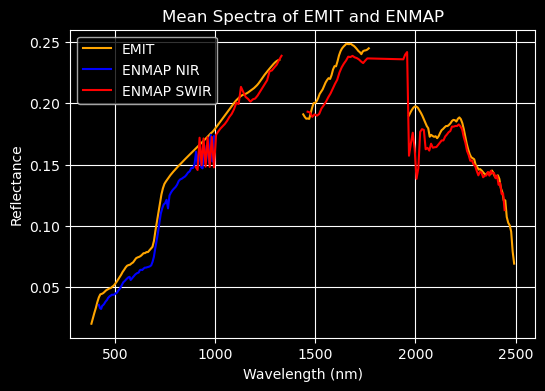

In [71]:
#plot the mean spectra of emit and enmap


# Make a wide plot
plt.figure(figsize=(6, 4))

plt.plot(emit_wavelengths, emit_sample.mean(axis=0), label='EMIT', color='orange')
plt.plot(enmap_nir_wavelengths, enmap_nir_sample.mean(axis=0), label='ENMAP NIR', color='blue')
plt.plot(enmap_swir_wavelengths, enmap_swir_sample.mean(axis=0), label='ENMAP SWIR', color='red')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Mean Spectra of EMIT and ENMAP')
plt.legend()
plt.grid(True)

